<a href="https://colab.research.google.com/github/Karim-Anwar/masterProject/blob/main/preporcess_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import scipy
import datetime
import glob

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
# Partial Autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
import seaborn as sns

In [ ]:
from statsmodels.tsa.stattools import ccf

In [ ]:
import os
import re

In [ ]:
def read_csv_files_from_directories(root_directory):
    directories = []
    for root, dirs, files in os.walk(root_directory):
        for file in files:
            if file.endswith('.csv'):
                directories.append(root)
                break
    return directories

In [ ]:
# def extract_numbers_from_csv_names(root_directory):
#     numbers = []
#     pattern = r'TL(\d+)\.csv'

#     for dirpath, dirnames, filenames in os.walk(root_directory):
#       # if dirpath == root_directory:
#       # # Skip the root directory
#       #   continue
#       for file_name in filenames:
#           if file_name.endswith('.csv'):
#               match = re.search(pattern, file_name)
#               if match:
#                   extracted_number = match.group(1)
#                   numbers.append(int(extracted_number))

#     return numbers

In [ ]:
def extract_numbers_from_csv_names(file_name):
    numbers = []
    pattern = r'TL(\d+)\.csv'

    match = re.search(pattern, file_name)
    if match:
        extracted_number = match.group(1)
        numbers.append(int(extracted_number))

    return numbers

In [ ]:
def extract_direction_from_subdirectories(root_directory):
    directions = []
    pattern = r'.*([ENSW])$'

    for dirpath, dirnames, filenames in os.walk(root_directory):
        for dirname in dirnames:
            match = re.search(pattern, dirname)
            if match:
                extracted_direction = match.group(1)
                directions.append(extracted_direction)

    return directions

In [ ]:
def get_fill_method(number):
    if number < 10:
        return 'ffill'  # Fill forward
    elif number % 10 == 1:
        return 'backfill'  # Backward fill
    elif number % 10 == 2:
        return 'interpolate'  # Linear interpolation
    else:
        return None

In [ ]:
def read_and_resample_csv_files(directory, start_index=None, end_index=None):
    dataframes = []
    file_names = os.listdir(directory)


    for file_name in file_names:
      if file_name.endswith('.csv'):
          file_path = os.path.join(directory, file_name)

          df = pd.read_csv(file_path)
          fill_method = get_fill_method(extract_numbers_from_csv_names(file_name)[0])

          if fill_method is None:
            return None
          elif fill_method == 'linear':
            return None

          df.columns = ['seq', 'time', 'value']

          # Drop the 'seq' column
          if 'seq' in df.columns:
              df.drop('seq', axis=1, inplace=True)

          df['time'] = pd.to_datetime(df['time'])
          df.set_index('time', inplace=True)

          df = df.loc[~df.index.duplicated(keep='first')]

          # Sort the index in ascending order
          df.sort_index(inplace=True)


          if fill_method == 'interpolate':
            resampled_df = df.asfreq('1S').interpolate(method='linear')
          else:
            resampled_df = df.asfreq('1S', method=fill_method)


          if start_index is not None and end_index is not None:
              resampled_df = resampled_df.loc[start_index:end_index]

      dataframes.append(resampled_df)

    if dataframes:
      merged_df = pd.concat(dataframes, axis=1)

      merged_df.columns = ['pir', 'shade', 'alight'] # Rename columns based on the number
      return merged_df

    return None

In [ ]:
root_directory = '/content/drive/MyDrive/exploratory-data-analysis/data/'
output_directory = '/content/drive/MyDrive/exploratory-data-analysis/cleaned_data'
# Step 1: Read CSV files from multiple directories
directories = read_csv_files_from_directories(root_directory)[1:]

# Step 2: Read and merge CSV files from the same directory
merged_dataframes = []
for directory in directories:
    merged_df = read_and_resample_csv_files(directory, start_index='2023-03-22 00:20:00', end_index='2023-05-19 12:10:00')
    if merged_df is not None:
        merged_dataframes.append(merged_df)

for i, df in enumerate(merged_dataframes):
    original_directory = directories[i]
    directory_name = os.path.basename(original_directory)
    file_name = f'{directory_name}.csv'
    file_path = os.path.join(output_directory, file_name)
    df.to_csv(file_path, index=True)

In [ ]:
merged_dataframes

In [ ]:
# Directory paths
resampled_directory = '/content/drive/MyDrive/exploratory-data-analysis/data'
second_directory = '/content/drive/MyDrive/exploratory-data-analysis/cleaned_data_not'
output_directory = '/content/drive/MyDrive/exploratory-data-analysis/cleaned_data'


# Perform resampling and interpolation
start_index = '2023-03-22 00:20:00'
end_index = '2023-05-19 12:10:00'


# Read and resample the North, East, South, and West CSVs
def resample_csv(csv_path):
    df = pd.read_csv(csv_path, parse_dates=['time'], index_col='time', names=['seq', 'time', 'value'])
    df = df.drop(['seq'], axis=1)

    # Drop duplicate timestamps
    df = df.loc[~df.index.duplicated(keep='first')]
    # Sort the index in ascending order
    df.sort_index(inplace=True)

    # Resample and interpolate
    df = df.asfreq('1S').interpolate(method='linear').loc[start_index:end_index]
    return df

north_df = resample_csv(os.path.join(resampled_directory, 'North.csv'))
east_df = resample_csv(os.path.join(resampled_directory, 'East.csv'))
south_df = resample_csv(os.path.join(resampled_directory, 'South.csv'))
west_df = resample_csv(os.path.join(resampled_directory, 'West.csv'))

# Create a dictionary mapping direction to dataframe
direction_mapping = {'N': north_df, 'E': east_df, 'S': south_df, 'W': west_df}

# Iterate over the second directory CSVs
for file_name in os.listdir(second_directory):
    if file_name.endswith('.csv'):
        # Extract the direction from the file name
        direction = file_name.split('_')[-1][0]

         # Read the CSV file and set the 'time' column as index
        second_df = pd.read_csv(os.path.join(second_directory, file_name), parse_dates=['time'], index_col='time')

        # Merge with the corresponding resampled dataframe
        if direction in direction_mapping:
            merged_df =pd.merge(second_df, direction_mapping[direction], left_index=True, right_index=True)

            # Save the merged dataframe with the original filename
            output_filename = os.path.join(output_directory, os.path.splitext(file_name)[0] + '.csv')
            merged_df.to_csv(output_filename, index=True, index_label='time')  # Set index=True to include the 'time' index

In [ ]:
new = pd.read_csv('/content/drive/MyDrive/exploratory-data-analysis/cleaned_data/05_N62_W.csv', parse_dates=['time'], index_col='time')

In [ ]:
new['pir'] = new['pir'].fillna(0)

In [ ]:
new.head()

,pir,shade,alight,value
time,,,,
2023-03-22 00:20:00,0.0,0.0,0.0,0.0
2023-03-22 00:20:01,0.0,0.0,0.0,0.0
2023-03-22 00:20:02,0.0,0.0,0.0,0.0
2023-03-22 00:20:03,0.0,0.0,0.0,0.0
2023-03-22 00:20:04,0.0,0.0,0.0,0.0


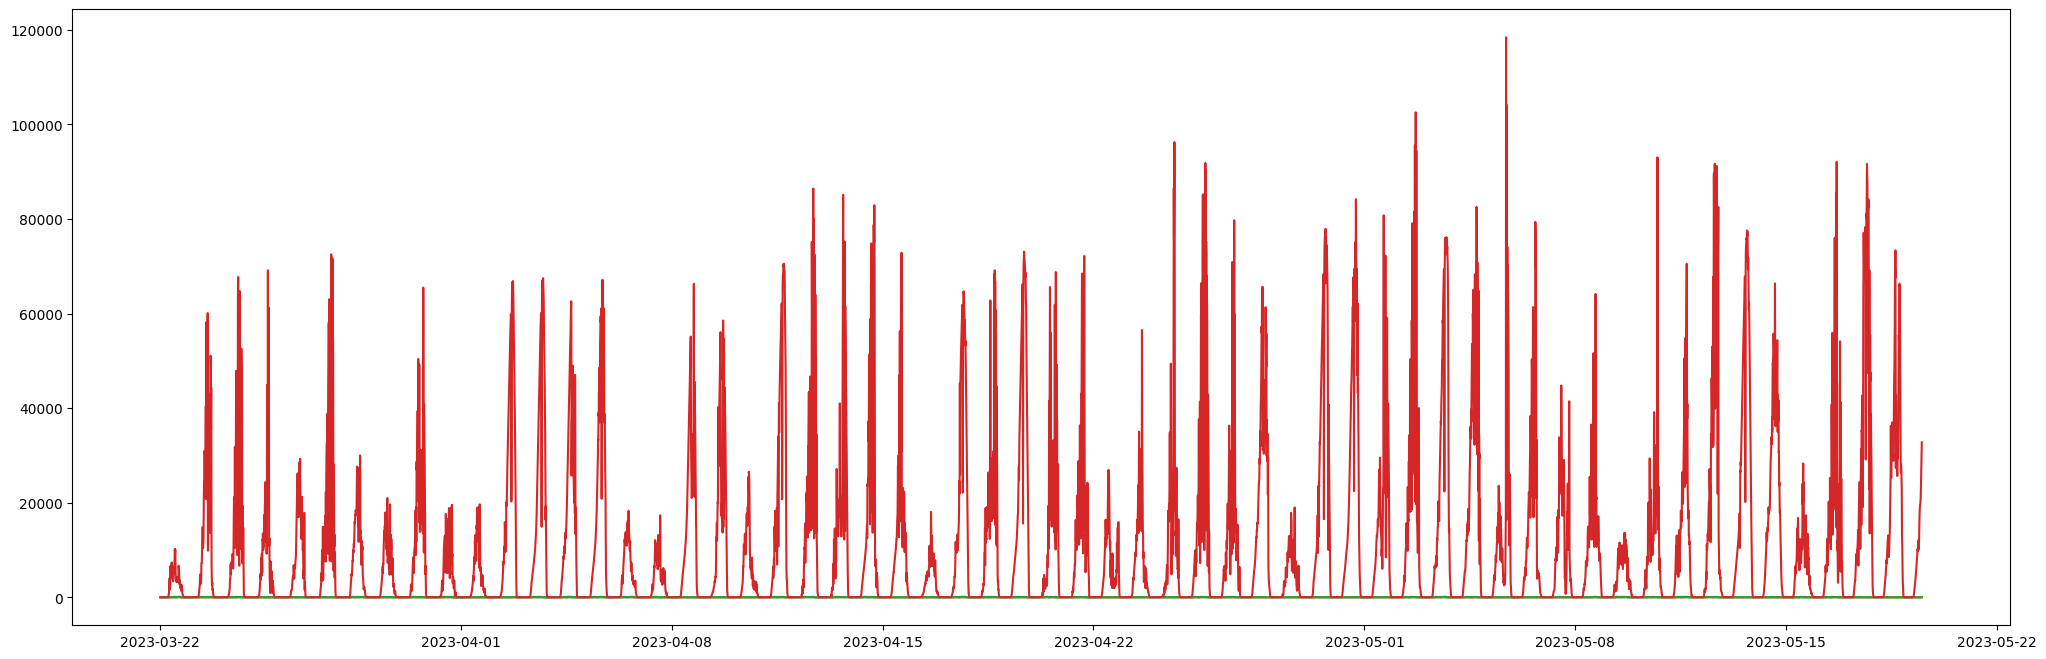

In [ ]:
plt.figure(figsize=(25, 8))
plt.plot(new)

In [ ]:
def minMaxnorm(df):
  normDF = (df-df.min())/(df.max()-df.min())
  return normDF

In [ ]:
normalized_data = minMaxnorm(new)

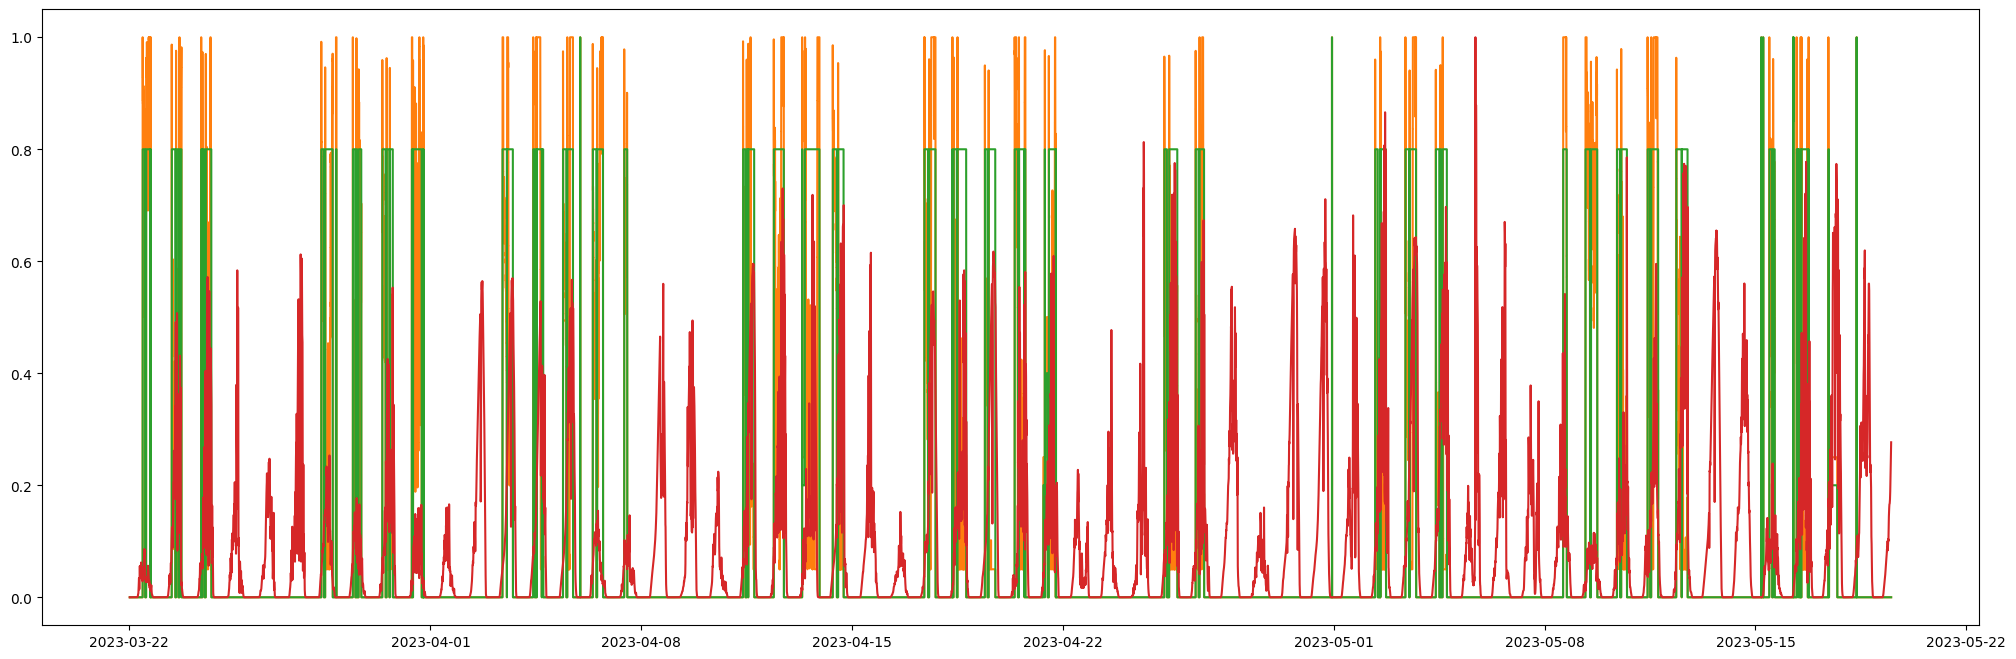

In [ ]:
plt.figure(figsize=(25, 8))
plt.plot(normalized_data)

In [ ]:
original_directory = '/content/drive/MyDrive/exploratory-data-analysis/cleaned_data'
# Directory path where you want to save the resampled datasets
resampled_directory = '/content/drive/MyDrive/exploratory-data-analysis/clnd_data_min'

# Pattern to match the dataset files (e.g., CSV files)
file_pattern = '*.csv'

# Get a list of file paths matching the pattern in the original directory
file_paths = glob.glob(os.path.join(original_directory, file_pattern))

# Process the datasets and resample them
for file_path in file_paths:
    # Extract the filename from the file path
    filename = os.path.basename(file_path)

    # Construct the output file path in the resampled directory with the same filename
    output_file_path = os.path.join(resampled_directory, filename)

    # Read the original dataset
    df = pd.read_csv(file_path, parse_dates=['time'], index_col='time')

    # Resample the dataset to per minute frequency
    resampled_df = df.resample('1T').mean()

    # Save the resampled dataset as a new CSV file
    resampled_df.to_csv(output_file_path)